In [1]:
# !pip install umap-learn torch numpy matplotlib scikit-learn tqdm

In [11]:
import h5py
import numpy as np
import os 

encodings_dir = "/Users/emma/Desktop/QUEENS/THESIS/contrastive/histopathology_inputs/data/UNI2_panda_encodings_by_patch"
files = [f for f in os.listdir(encodings_dir) if os.path.isfile(os.path.join(encodings_dir, f))]
file = os.path.join(encodings_dir, files[2])


In [12]:


with h5py.File(file, "r") as f:
    # Print top-level keys (groups/datasets)
    print("Keys in file:", list(f.keys()))
    print()

    for key in f.keys():
        obj = f[key]
        if isinstance(obj, h5py.Dataset):
            print(f"{key}: dataset, shape={obj.shape}, dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"{key}: group with subkeys {list(obj.keys())}")
        else:
            print(f"{key}: unknown type {type(obj)}")


Keys in file: ['annot_label', 'annots', 'coords', 'coords_patching', 'features']

annot_label: dataset, shape=(487, 1), dtype=int64
annots: dataset, shape=(1, 487, 1), dtype=int64
coords: dataset, shape=(1, 487, 2), dtype=int64
coords_patching: dataset, shape=(487, 2), dtype=int64
features: dataset, shape=(1, 487, 1536), dtype=float32


ISUP distribution:
ISUP 0: 2891
ISUP 1: 2666
ISUP 2: 1343
ISUP 3: 1242
ISUP 4: 1249
ISUP 5: 1224


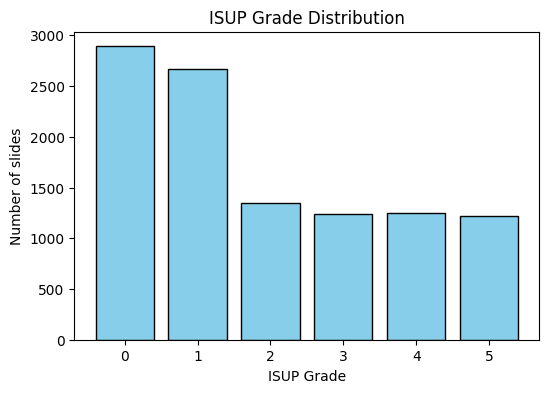

In [13]:
import os
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter()

for fname in os.listdir(encodings_dir):
    if not fname.endswith(".h5"):
        continue

    parts = os.path.splitext(fname)[0].split("_")
    if len(parts) > 1:
        isup = parts[-1]
        counts[isup] += 1
    else:
        print(f"Skipping file without ISUP suffix: {fname}")

# Sort by ISUP grade numerically
grades = sorted(counts.keys(), key=int)
values = [counts[g] for g in grades]

# Print counts
print("ISUP distribution:")
for g, n in zip(grades, values):
    print(f"ISUP {g}: {n}")

# Plot
plt.figure(figsize=(6,4))
plt.bar(grades, values, color="skyblue", edgecolor="black")
plt.xlabel("ISUP Grade")
plt.ylabel("Number of slides")
plt.title("ISUP Grade Distribution")
plt.show()


Fold 0: {0: 469, 1: 431, 2: 218, 3: 201, 4: 203, 5: 198}
Fold 1: {0: 469, 1: 432, 2: 217, 3: 202, 4: 202, 5: 198}
Fold 2: {0: 469, 1: 432, 2: 217, 3: 201, 4: 202, 5: 199}
Fold 3: {0: 468, 1: 432, 2: 218, 3: 201, 4: 202, 5: 199}
Fold 4: {0: 468, 1: 432, 2: 218, 3: 201, 4: 202, 5: 198}


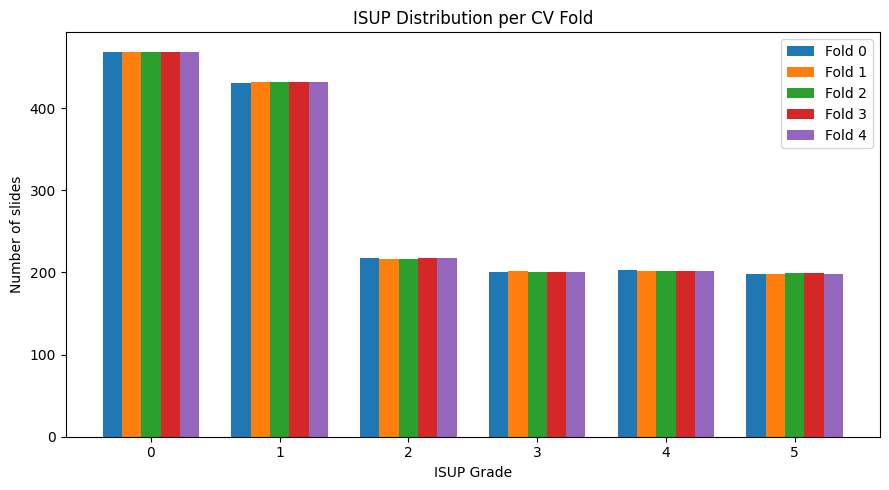

TEST: {0: 260, 1: 240, 2: 121, 3: 112, 4: 113, 5: 110}


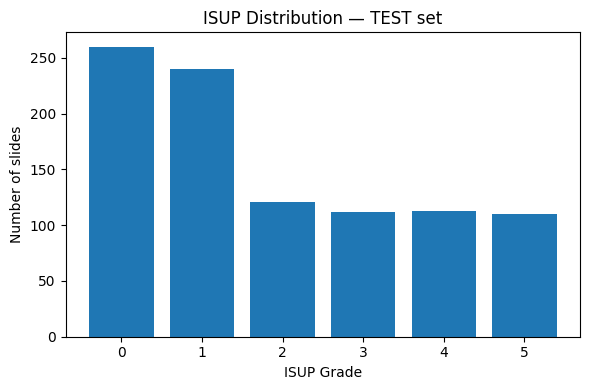

In [1]:
#PER FOLD
import pandas as pd
import matplotlib.pyplot as plt

manifest_csv = "panda_clean_noise10_folds.csv"
man = pd.read_csv(manifest_csv)

# Ensure types
man["isup_grade"] = man["isup_grade"].astype(int)

# ----- (A) Plot CV folds only -----
cv = man[man["split"] == "cv"].copy()
fold_ids = sorted(cv["fold"].unique())
labels = sorted(cv["isup_grade"].unique())

# counts per fold
counts_per_fold = []
for f in fold_ids:
    sub = cv[cv["fold"] == f]["isup_grade"].value_counts().reindex(labels, fill_value=0)
    print(f"Fold {f}:", dict(sub))
    counts_per_fold.append(sub.values)

# grouped bar chart
bar_width = 0.15
x = range(len(labels))

plt.figure(figsize=(9,5))
for i, counts in enumerate(counts_per_fold):
    plt.bar([xi + i*bar_width for xi in x], counts, width=bar_width, label=f"Fold {fold_ids[i]}")
plt.xticks([xi + (len(counts_per_fold)-1)*bar_width/2 for xi in x], labels)
plt.xlabel("ISUP Grade")
plt.ylabel("Number of slides")
plt.title("ISUP Distribution per CV Fold")
plt.legend()
plt.tight_layout()
plt.show()

# ----- (B) (Optional) Show TEST distribution separately -----
test = man[man["split"] == "test"].copy()
if len(test):
    test_counts = test["isup_grade"].value_counts().reindex(labels, fill_value=0)
    print("TEST:", dict(test_counts))

    plt.figure(figsize=(6,4))
    plt.bar([str(l) for l in labels], test_counts.values)
    plt.xlabel("ISUP Grade")
    plt.ylabel("Number of slides")
    plt.title("ISUP Distribution — TEST set")
    plt.tight_layout()
    plt.show()
else:
    print("No rows with split == 'test' found in manifest.")


In [18]:
#INSPECT MASKS

import h5py
import numpy as np

filepath = "/Users/emma/Desktop/QUEENS/THESIS/contrastive/histopathology_inputs/data/UNI2_panda_encodings_by_patch/a9635e180394f1ed176bed3581cac969_0.h5"

with h5py.File(filepath, "r") as f:
    # Inspect annot_label
    if "annot_label" in f:
        annot_label = f["annot_label"][:]
        print("annot_label:")
        print("  shape:", annot_label.shape)
        print("  dtype:", annot_label.dtype)
        print("  values:", annot_label[:10])  # first 10
        print("  unique values:", np.unique(annot_label))

    # Inspect annots
    if "annots" in f:
        annots = f["annots"][:]
        print("\nannots:")
        print("  shape:", annots.shape)
        print("  dtype:", annots.dtype)
        print("  first 10 values:", annots.reshape(-1)[:10])  
        print("  unique values:", np.unique(annots))


annot_label:
  shape: (483, 1)
  dtype: int64
  values: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
  unique values: [0]

annots:
  shape: (1, 483, 1)
  dtype: int64
  first 10 values: [0 0 0 0 0 0 0 0 0 0]
  unique values: [0]


In [19]:
import os, h5py, numpy as np

enc_dir = "/Users/emma/Desktop/QUEENS/THESIS/contrastive/histopathology_inputs/data/UNI2_panda_encodings_by_patch"
nonzero = []

for fname in os.listdir(enc_dir):
    if not fname.endswith(".h5"): 
        continue
    path = os.path.join(enc_dir, fname)
    with h5py.File(path, "r") as f:
        for key in ("annot_label", "annots"):
            if key in f:
                arr = f[key][()]
                if np.any(arr != 0):
                    nonzero.append((fname, key, np.unique(arr).tolist()))
                    break

if nonzero:
    print("Found files with nonzero patch labels:")
    for item in nonzero:
        print(item)
else:
    print("All annot_label/annots are zero (or absent). Safe to ignore.")


All annot_label/annots are zero (or absent). Safe to ignore.
